# Load Data

In [1]:
import pandas as pd

# read dataframe
cards_df = pd.read_pickle('mtg_data/cards_df.pickle')

# filter out non mono colored cards and shuffle dataframe
cards_df = cards_df[cards_df['encoding']!=5]
cards_df = cards_df.sample(frac=1).reset_index(drop=True)
cards_df.loc[0, :]

colorIdentity                                                   [B]
convertedManaCost                                               3.0
name                                                       Mind Rot
originalText                      Target player discards two cards.
types                                                     [Sorcery]
ja_name                                                        精神腐敗
ja_text                            プレイヤー１人を対象とする。そのプレイヤーはカードを２枚捨てる。
ja_type                                                       ソーサリー
ja_flavorText        「発想の源が失われるのは悲しいものがある。今回のは特に有望そうだったのだが。」 ――アショク
encoding                                                          2
en_toks                                                 [mind, rot]
ja_toks                                                    [精神, 腐敗]
Name: 0, dtype: object

# Capturing the Essence of Each Color

### The first thing I want to do is see if I can capture the essence of each color by looking at their token frequencies

In [2]:
from collections import Counter, defaultdict

word_freqs = defaultdict(list)
color_symbol = {0: 'White', 1: 'Blue', 2: 'Black', 3: 'Red', 4: 'Green'}

for i in range(5):
    card_names = cards_df[cards_df['encoding']==i]['en_toks'].tolist()
    flattened = [t for tokens in card_names for t in tokens]
    freqs = Counter(flattened).most_common(20)
    word_freqs[color_symbol[i]] = [tup[0] for tup in freqs]

In [3]:
from tabulate import tabulate
print(tabulate(word_freqs, headers='keys', tablefmt='rst'))

========  =========  =========  =========  =========
White     Blue       Black      Red        Green
========  =========  =========  =========  =========
angel     drake      vampire    goblin     wurm
griffin   sphinx     blood      fire       druid
knight    merfolk    death      dragon     spider
aven      aether     dead       flame      nature
light     jace       phyrexian  lightning  elemental
guardian  serpent    dark       ogre       wild
spirit    aven       ghoul      rage       growth
sliver    elemental  cabal      giant      wolf
kor       thought    plague     war        dryad
guard     mage       demon      elemental  vine
serra     dream      shade      fury       primal
shield    wind       witch      burn       elvish
paladin   psychic    grave      minotaur   strength
soul      mystic     rat        viashino   hunt
angelic   cephalid   zombie     shaman     behemoth
gideon    mind       soul       mage       troll
master    faerie     night      storm      krosan
d

### This is pretty interesting! This table lists words that give us an insight into aspects of each color. 
### For starters, you can see which creatures are most characterstic of each color. Angels for White, Drakes for Blue, Vampires for Black, Goblins for Red, and Wurms for Green. If someone familiar with mtg were asked to give a representative creature for each color, I could totally see them naming each of these (with the exception of maybe Drakes for Blue)
### There are also a variety of creature classes associated with each color. Paladins for White, Shamans for Red, etc.
### But maybe what captures each color's essence the most are the non creature type/class related words. Word's like fury and rage for Red, and growth and wild for Green.  

### Since tokens are unique across colors, I want to see if a model can learn to distinguish card colors given each card's name alone. There are definitely tokens that appear in more than one color though; the word elemental for example shows up in Blue, Red, and Green. But let's see how a model performs

# BOW Feature Extraction

### Since I'm focusing on the words that make up each card name regardless of sequence, I'm going to use a simple a BOW vectorizer 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer

en_tokens = cards_df['en_toks'].values
y = cards_df['encoding'].values

tokens_train, tokens_test, y_train, y_test = train_test_split(en_tokens, y, test_size = 0.25, random_state=1000)

# disable analyzer since I'm applying CountVectorizer to list of lemms
vectorizer = CountVectorizer(analyzer=lambda x: x)

# fit_tranform is used for iterable of strings, it combines the fit and transform steps
X_train = vectorizer.fit_transform(tokens_train)
X_test = vectorizer.transform(tokens_test)

print(X_train.shape)
print(X_test.shape)

(8055, 6869)
(2685, 6869)


# Naive Bayes MultinomialNB

### Since this is a multiclass classification task, I'm going to use Scikit's Naive Bayes MultinomialNB model. I also tried implementing a simple ANN using Pytorch but the accuracy wasn't that far off from the Scikit model. Since the Scikit model is less code I'll just stick with it for this notebook

In [5]:
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.5813780260707635


### 58% isn't great, but it's still better than a 20% random guess. Let's take a look at where the model's going wrong using a confusion matrix

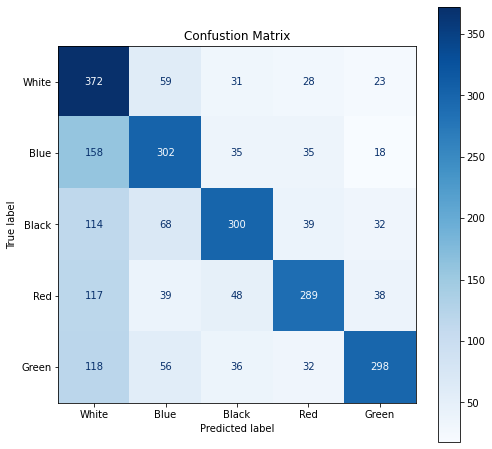

In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(8, 8))
disp = plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=['White', 'Blue', 'Black', 'Red', 'Green'],
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title('Confustion Matrix')
plt.show()

### It looks like the model is miscategorizing cards as White the most, no matter which color they actually are. I wonder what it is about White that gives the model a disposition towards it. Perhaps it shares more in common with each of the other colors than any of them do with each other. 
### I want to take a look at some examples though and see if I can blame the model for some of these miscategorizations

In [7]:
false_blacks = defaultdict(list)

for x, y, p in zip(tokens_test, y_test, y_pred):
    if color_symbol[y] != 'White' and color_symbol[p] == 'White':
        false_blacks['card_name'] += [' '.join(x)]
        false_blacks['actual'] += [color_symbol[y]]
        false_blacks['predicted'] += [color_symbol[p]]
    if len(false_blacks['card_name']) >= 10:
        break

print(tabulate(false_blacks, headers='keys', tablefmt='fancy_grid'))

╒═════════════════════╤══════════╤═════════════╕
│ card_name           │ actual   │ predicted   │
╞═════════════════════╪══════════╪═════════════╡
│ pith driller        │ Black    │ White       │
├─────────────────────┼──────────┼─────────────┤
│ spelltwine          │ Blue     │ White       │
├─────────────────────┼──────────┼─────────────┤
│ blightcaster        │ Black    │ White       │
├─────────────────────┼──────────┼─────────────┤
│ fblthp lost         │ Blue     │ White       │
├─────────────────────┼──────────┼─────────────┤
│ zealous conscript   │ Red      │ White       │
├─────────────────────┼──────────┼─────────────┤
│ akroan line breaker │ Red      │ White       │
├─────────────────────┼──────────┼─────────────┤
│ soulstinger         │ Black    │ White       │
├─────────────────────┼──────────┼─────────────┤
│ pedantic learning   │ Blue     │ White       │
├─────────────────────┼──────────┼─────────────┤
│ turn dust           │ Green    │ White       │
├───────────────────

### For cards like Zealous Conscript I can't really blame the model, I would guess White as well in that case. But Blightcaster I might correctly categorize as Black. It may be that there simply isn't enough uniqueness in the distribution of tokens across colors. I can't help but wonder how well I would do if someone asked me to categorize 10 random cards. 
### But maybe English itself has something to do with it. One thing I noticed is that Spacy doesn't split up compound nouns when tokenizing; I wonder if the model's accuracy would change if a word like Soulstinger was split into Soul and Stinger. On the other hand Spacy usually does split up these sorts of compounds in Japanese. So as a last experiment I want to see if the model performs any better or worse with Japanese, and what colors it might miscategorize. 

# Testing the Model on Japanese

In [8]:
word_freqs = defaultdict(list)
color_symbol = {0: 'White', 1: 'Blue', 2: 'Black', 3: 'Red', 4: 'Green'}

for i in range(5):
    card_names = cards_df[cards_df['encoding']==i]['ja_toks'].tolist()
    flattened = [t for tokens in card_names for t in tokens]
    freqs = Counter(flattened).most_common(20)
    word_freqs[color_symbol[i]] = [tup[0] for tup in freqs]

In [9]:
# Token frequencies for each color

from tabulate import tabulate
print(tabulate(word_freqs, headers='keys', tablefmt='rst'))

==========  ============  ==============  ============  ========
White       Blue          Black           Red           Green
==========  ============  ==============  ============  ========
者          者            者              者            者
天使        ドレイク      鬼              ゴブリン      獣
騎士        師            吸血            炎            ワーム
兵          士            血              火            蜘蛛
官          霧            死              稲妻          森
グリフィン  精神          影              血            エルフ
士          魔道          悪魔            ドラゴン      群れ
光          空            屍              士            自然
魂          呪文          闇              憤怒          ドルイド
盾          夢            骨              溶岩          力
聖          風            グール          オーガ        狼
エイヴン    大            魂              巨人          大
人          スフィンクス  精神            魔道          地
守護        マーフォーク  夜              怒り          捕食
太陽        翼            ファイレクシア  精霊          ウッド
神          思考          墓              

In [10]:
# BOW vectorizer

ja_tokens = cards_df['ja_toks'].values
y = cards_df['encoding'].values

tokens_train, tokens_test, y_train, y_test = train_test_split(ja_tokens, y, test_size = 0.25, random_state=1000)

# disable analyzer since I'm applying CountVectorizer to list of lemms
vectorizer = CountVectorizer(analyzer=lambda x: x)

# fit_tranform is used for iterable of strings, it combines the fit and transform steps
X_train = vectorizer.fit_transform(tokens_train)
X_test = vectorizer.transform(tokens_test)

print(X_train.shape)
print(X_test.shape)

(8055, 6202)
(2685, 6202)


In [11]:
# Classification model

clf = MultinomialNB()
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)
print("Accuracy:", metrics.accuracy_score(y_test, y_pred))

Accuracy: 0.6022346368715084


### 60%! That's just a little better than the English model. So it looks like the choice of language doesn't have that much of an impact. Let's look at the confusion matrix

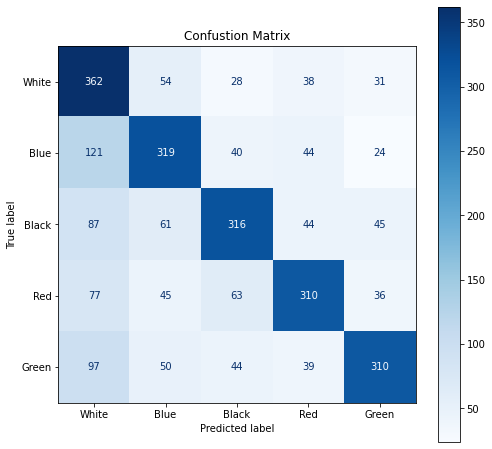

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(8, 8))
disp = plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=['White', 'Blue', 'Black', 'Red', 'Green'],
                             cmap=plt.cm.Blues,
                             normalize=None,
                             ax=ax)
disp.ax_.set_title('Confustion Matrix')
plt.show()

### Intersting! It looks like the model is still tending towards White. 
### In the game, each color is allied with two colors and opposed to two. I think it would have been fascinating if the model mistook each color for the colors that it's allied with. This actually happens with Blue to an extent in the English model but not with any colors in the Japanese model.  